# Module 3: Tensorflow 2

* Tensorflow is a Python library for modeling differentiable graphs of functions
* We will convert our nonlinear model code to Tensorflow in this module

First, look at some basic tensorflow operations.

In [2]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

In [30]:
# make constant tensors
A = tf.constant([[3, 4], [5, 6]])
B = tf.constant([[0, 1], [1, 0]])

# add them up
R = A + B
print(R)

# transpose (flip rows and columns)
print(tf.transpose(R))

# matrix multiplication
R = tf.matmul(A, tf.constant([[1], [1]]))
print(R)

# element-wise multiplication
R = tf.multiply(A, B)
print(R)

# make an identity matrix
I = tf.eye(3)
print(I)

# shape access: static vs. dynamic
print(I.shape)
print(tf.shape(I))

# going from tensorflow to numpy
print(A.numpy())
print(B.numpy())

# access: notice that it returns a tensor
print(A[0, 0])

# equality check, again it returns a tensor
print(A[0, 0] == 3)

# go to numpy to get truthiness
print((A[0,0] == 3).numpy())

tf.Tensor(
[[3 5]
 [6 6]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[3 6]
 [5 6]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 7]
 [11]], shape=(2, 1), dtype=int32)
tf.Tensor(
[[0 4]
 [5 0]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)
(3, 3)
tf.Tensor([3 3], shape=(2,), dtype=int32)
[[3 4]
 [5 6]]
[[0 1]
 [1 0]]
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(True, shape=(), dtype=bool)
True


## What is the big deal?

* So far, this looks like just another numpy-like library. So what is the point? the point is automatic differentiaion.
* Let's take a look at a simple example: we'll use tensorflow to compute the derivative of an arbitary mathematical function with respect to the inputs.

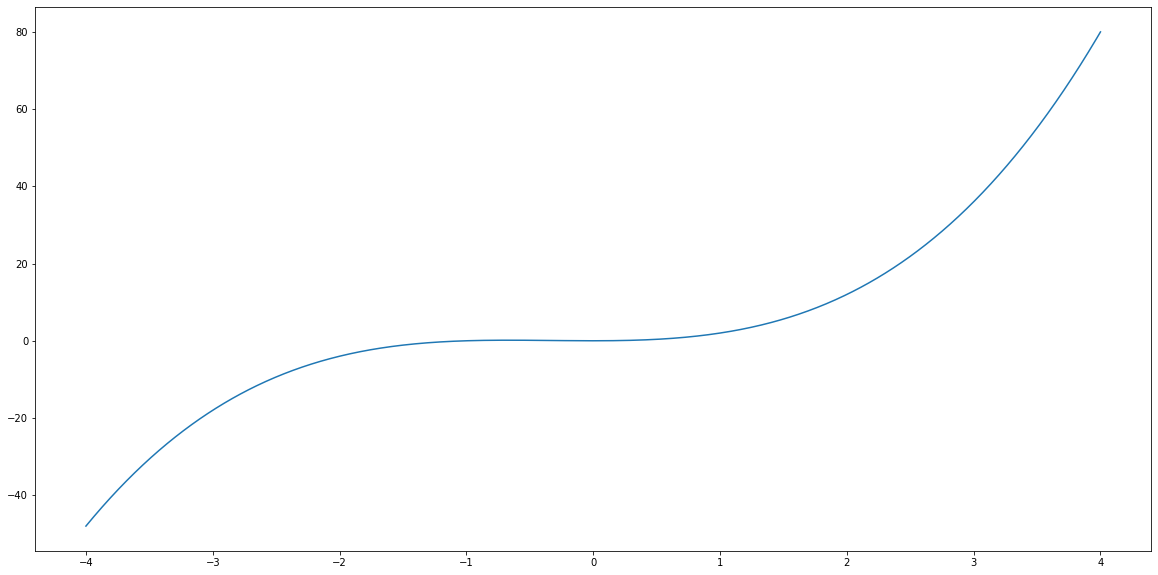

In [43]:
# define some mathematical function
def gelu(x):
    return np.power(x, 2) + np.power(x, 3)

# plot
xstar = np.linspace(-4, 4, 1000)
ystar = gelu(xstar)
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(xstar, ystar)

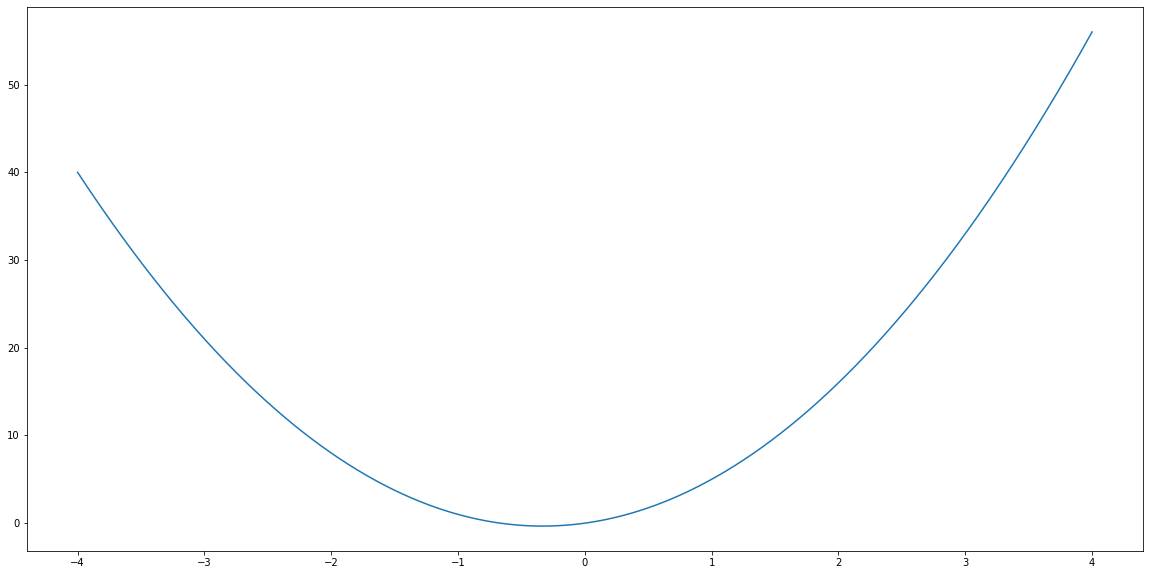

In [49]:
# define the same function in tensorflow
def gelu_tf(x):
    return tf.pow(x, 2) + tf.pow(x, 3)

# compute the gradient with respect to the input
xstar_tf = tf.Variable(xstar)
with tf.GradientTape() as gt:
    y = gelu_tf(xstar_tf)
    gradient = gt.gradient(y, xstar_tf).numpy()

# plot the gradient
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(xstar, gradient)

* Here, the `GradientTape()` class keeps track of all forward tensorflow computations done within in the `with` block.
* When you are ready to get the gradients, you call the `gradient()` function which accepts a tensorflow expression and the variable to differentiate against.

## Reimplementing the Nonlinear Model in Tensorflow

* We'll reimplement the gradient descent code of the nonlinear model from Module 2 in Tensorflow.

In [62]:
import numpy.random as rng 

# read data
data = np.load('code/day2/fake_data.npz')
X, y = data['X'], data['y']

# move data to tensorflow space
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# randomly initialize model parameters (beta0, beta1, gamma0, gamma1)
theta = tf.Variable(rng.randn(4), dtype=tf.float32)

# create optimizer
# in addition to vanilla gradient descent optimizer,
# tensorflow has multiple optimizers available.
# here we use the vanilla optimizer, known as 
# stochastic gradient descent
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# repeat N times
N = 200
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        linear_part = theta[0] + theta[1] * X 
        g = tf.cos(linear_part)
        ypred = theta[2] + theta[3] * g
        
        # loss
        mse_loss = tf.reduce_mean(tf.square(ypred - y))
        
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    dloss_dtheta = gt.gradient(mse_loss, theta)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients([(dloss_dtheta, theta)])
    
# report results
linear_part = theta[0] + theta[1] * X 
g = tf.cos(linear_part)
ypred = theta[2] + theta[3] * g
mse_loss = tf.reduce_mean(tf.square(ypred - y))
print("Final MSE: %0.4f" % mse_loss.numpy())
final_theta = theta.numpy()
print(final_theta)


Final MSE: 2.4110
[ 0.44812888 -1.5074573   0.3127674   1.0748645 ]


* We only needed to specify the forward computation in tensorflow, and the library took care of the backward pass (the more difficult part!)
* The optimizer is responsible for applying the update rule. Here we are using a vanilla optimizer with a fixed learning rate, but Tensorflow supports optimizers that adapt learning rates